# 🎬 RecommEngineX 1.0 — Your Ultimate Movie Recommendation Companion

Welcome to **RecommEngineX 1.0**, a cutting-edge hybrid recommendation engine crafted to deliver **personalized movie suggestions** perfectly aligned with your unique preferences.

## ✨ **What makes RecommEngineX special?**  
- Combines powerful **collaborative filtering techniques**, including **Matrix Factorization (SVD)** and **Item-based Neighborhood (KNNWithMeans)**, for highly accurate and relevant recommendations.  
- Integrates **Google Gemini’s advanced AI-powered explanations**, giving you clear insights into *why* each movie is recommended — boosting transparency and trust.  
- Features an intuitive, interactive interface designed to make your movie discovery experience effortless and enjoyable.  

Whether you're a cinephile or casual viewer, RecommEngineX 1.0 goes beyond suggestions — it empowers you with understanding and confidence to explore your next favorite film.

### 🎥 **Ready to dive in? Let’s find your perfect movie match today!**


### 📥 Downloading & Extracting the MovieLens Dataset

This step downloads the popular MovieLens 100k dataset from GroupLens and extracts its contents for use.  
The dataset contains user ratings and movie metadata, forming the foundation for training and evaluating our recommendation system.

- `wget` retrieves the compressed dataset file.
- `unzip` decompresses and prepares the data files for analysis.
- [source](https://grouplens.org/datasets/movielens/)

In [1]:
!wget -q http://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip -q ml-100k.zip

replace ml-100k/allbut.pl? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


## 🔧 Setup: Importing Libraries

This cell loads all the key libraries required for data manipulation, model creation, evaluation, and visualization in our recommendation system.  
It also incorporates utilities for secure secret management and integration with generative AI APIs, ensuring a seamless and efficient development workflow throughout the project.


In [2]:
import sys
import os
import csv
import pandas as pd
import numpy as np
from datetime import datetime
import surprise
from kaggle_secrets import UserSecretsClient
import google.generativeai as genai
from IPython.display import Markdown, display
from surprise import SVD, Dataset, Reader, accuracy, KNNWithMeans
from surprise.model_selection import train_test_split
import matplotlib.pyplot as plt
from collections import defaultdict

### ⚙️ Library Version Check

- ✅ Prints current versions of:
  - `Python` (expected: **3.11**)
  - `NumPy` (expected: **1.26.4**)
  - `Pandas`
  - `Surprise`
- ⚠️ Asserts `Python` and `NumPy` versions to ensure compatibility  
- ❗ `Surprise` version check may raise an error if not imported properly


In [3]:
print(f"Python: {sys.version.split()[0]}")
print(f"NumPy: {np.__version__} (Expected: 1.26.4)")
print(f"Pandas: {pd.__version__} (Expected: 2.2.3)")
print(f"Surprise: {surprise.__version__} (Expected: 1.1.4)")

assert sys.version_info[:2] == (3, 11), "Wrong Python version!"
assert np.__version__ == '1.26.4', "NumPy version mismatch!"

Python: 3.11.11
NumPy: 1.26.4 (Expected: 1.26.4)
Pandas: 2.2.3 (Expected: 2.2.3)
Surprise: 1.1.4 (Expected: 1.1.4)


## 🔑 Configuring Google Generative AI API

This block securely retrieves the Google API key from Kaggle secrets and configures the generative AI client.  
- Uses `UserSecretsClient` to keep the API key confidential.  
- Sets up the `genai` library for future AI-powered features in the app.  

*Note: The API key print statement is commented out to avoid exposing sensitive information.*


In [4]:
GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
genai.configure(api_key=GOOGLE_API_KEY)
# For testing only; don't print in real code
# print("API_KEY:", GOOGLE_API_KEY)  

## DataLoader Class: Loading and Preprocessing MovieLens Data

This class handles loading and preprocessing of the MovieLens 100k dataset, preparing it for recommendation modeling.

- **Ratings Data:** Loads user ratings with essential columns (`user_id`, `movie_id`, `rating`).
- **Movies Data:** Loads movie metadata including titles and detailed genre flags.
- **Genre Handling:** Converts individual genre columns into a single pipe-separated `genres` string for easier filtering and analysis.
- **Title Cleaning:** Removes year information from movie titles for a cleaner display and extracts the release year separately.

By encapsulating these steps, `DataLoader` provides a clean, ready-to-use dataset for building and evaluating recommendation algorithms.


In [5]:
class DataLoader:
    """Loads and preprocesses MovieLens data with genre handling"""
    
    def __init__(self):
        self.ratings_path = '/kaggle/working/ml-100k/u.data'
        self.movies_path = '/kaggle/working/ml-100k/u.item'
    
    def load_data(self):
        # Load ratings
        ratings = pd.read_csv(
            self.ratings_path,
            sep='\t',
            names=['user_id', 'movie_id', 'rating', 'timestamp'],
            usecols=['user_id', 'movie_id', 'rating']
        )
        
        # Load movies with genres
        movies = pd.read_csv(
            self.movies_path,
            sep='|',
            encoding='latin-1',
            header=None,
            names=[
                'movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url',
                'unknown', 'action', 'adventure', 'animation', 'children', 'comedy',
                'crime', 'documentary', 'drama', 'fantasy', 'film_noir', 'horror',
                'musical', 'mystery', 'romance', 'sci_fi', 'thriller', 'war', 'western'
            ]
        )
        
        # Create genres string
        genre_cols = [
            'unknown', 'action', 'adventure', 'animation', 'children', 'comedy',
            'crime', 'documentary', 'drama', 'fantasy', 'film_noir', 'horror',
            'musical', 'mystery', 'romance', 'sci_fi', 'thriller', 'war', 'western'
        ]
        movies['genres'] = movies[genre_cols].apply(
            lambda row: '|'.join([col for col, val in zip(genre_cols, row) if val == 1]),
            axis=1
        )
        
        # Clean titles
        movies['clean_title'] = movies['title'].str.replace(r'\(\d{4}\)', '', regex=True).str.strip()
        movies['release_year'] = movies['title'].str.extract(r'\((\d{4})\)')
        
        return ratings, movies[['movie_id', 'clean_title', 'release_year', 'genres']]


## RecommendationEngine Class: Hybrid Movie Recommendation System

This class implements a hybrid recommendation engine combining:

- **Matrix Factorization (SVD):** Captures latent user-item interactions.
- **Item-based Collaborative Filtering (KNNWithMeans):** Leverages item similarity with cosine distance.

Key features:

- **Training:** Builds models on the full dataset with proper train-test splitting.
- **Hybrid Scoring:** Blends SVD and item-CF predictions (70% / 30%) for more robust recommendations.
- **User-specific Recommendations:** Generates top-N personalized movie suggestions.
- **Cold Start Handling:** Falls back to popular movies if the user is new or unknown.
- **Genre Filtering:** Supports filtering recommended movies by genre for tailored results.

Robust ID handling ensures correct mapping between raw and inner IDs, preserving data integrity during predictions.


In [6]:
class RecommendationEngine:
    """Hybrid recommendation engine with proper ID handling and user-specific predictions"""
    
    def __init__(self, n_factors=50, n_epochs=20):
        # Initialize models
        self.svd = SVD(n_factors=n_factors, n_epochs=n_epochs)
        self.item_cf = KNNWithMeans(
            k=50,
            sim_options={'name': 'cosine', 'user_based': False}
        )
        self.reader = Reader(rating_scale=(1, 5))
        self.trainset = None
        self.testset = None

    def train(self, ratings_df):
        """Train both models with proper dataset splitting"""
        data = Dataset.load_from_df(
            ratings_df[['user_id', 'movie_id', 'rating']],
            self.reader
        )
        # Preserve raw IDs in testset
        self.trainset, self.testset = train_test_split(
            data, 
            test_size=0.2,
            random_state=42
        )
        self.trainset = data.build_full_trainset()
        
        # Train both models on full trainset
        self.svd.fit(self.trainset)
        self.item_cf.fit(self.trainset)

    def recommend(self, user_id, n=5):
        """Generate hybrid recommendations for specific user"""
        try:
            # Cold start handling
            if not self.trainset.knows_user(user_id):
                return self._popular_fallback(n)
            
            # Get user's inner ID
            inner_uid = self.trainset.to_inner_uid(user_id)
            
            # Get already rated items
            rated_items = {iid for (iid, _) in self.trainset.ur[inner_uid]}
            
            recommendations = []
            for inner_iid in self.trainset.all_items():
                if inner_iid not in rated_items:
                    raw_iid = self.trainset.to_raw_iid(inner_iid)
                    
                    # SVD prediction
                    svd_pred = self.svd.predict(
                        uid=user_id,
                        iid=raw_iid
                    ).est
                    
                    # Item-CF prediction
                    cf_pred = self.item_cf.predict(
                        uid=user_id,
                        iid=raw_iid
                    ).est
                    
                    # Blend predictions
                    blended_score = 0.7 * svd_pred + 0.3 * cf_pred
                    recommendations.append((raw_iid, blended_score))
            
            return sorted(recommendations, key=lambda x: x[1], reverse=True)[:n]
            
        except Exception as e:
            print(f"Recommendation error: {str(e)}")
            return self._popular_fallback(n)

    def _popular_fallback(self, n):
        """Fallback to popular movies with raw IDs"""
        movie_stats = defaultdict(list)
        for _, raw_iid, rating in self.trainset.all_ratings():
            movie_stats[raw_iid].append(rating)
            
        avg_ratings = {k: np.mean(v) for k, v in movie_stats.items()}
        return sorted(avg_ratings.items(), key=lambda x: x[1], reverse=True)[:n]

    def filter_by_genre(self, recommendations, movies_df, genre):
        """Filter recommendations by genre with safety checks"""
        if not isinstance(recommendations, list) or len(recommendations) == 0:
            return pd.DataFrame()
            
        movie_ids = [mid for mid, _ in recommendations]
        return movies_df[
            (movies_df['movie_id'].isin(movie_ids)) &
            (movies_df['genres'].str.contains(genre, case=False, na=False))
        ]


## Evaluator Class & Metrics Visualization

This section provides tools to assess recommendation quality:

- **Evaluator Class:**  
  - Calculates key metrics: RMSE, MAE for rating prediction accuracy.  
  - Computes Precision@k and Recall@k to evaluate recommendation relevance at cutoff k (default 10).  
  - Uses a rating threshold (3.5) to determine relevant recommendations.

- **plot_metrics Function:**  
  - Visualizes errors (RMSE, MAE) as bars.  
  - Overlays Precision and Recall scores as a line plot with dual y-axes for clear comparison.

Together, these enable comprehensive and intuitive performance analysis of the recommendation models.


In [7]:
class Evaluator:
    """Handles model evaluation metrics"""
    
    @staticmethod
    def calculate_precision_recall(predictions, k=10, threshold=3.5):
        user_est_true = defaultdict(list)
        for uid, _, true_r, est, _ in predictions:
            user_est_true[uid].append((est, true_r))
        
        precisions = []
        recalls = []
        for uid, user_ratings in user_est_true.items():
            user_ratings.sort(key=lambda x: x[0], reverse=True)
            n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
            n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
            n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold)
                                for (est, true_r) in user_ratings[:k]))
            
            precisions.append(n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0)
            recalls.append(n_rel_and_rec_k / n_rel if n_rel != 0 else 0)
        
        return np.mean(precisions), np.mean(recalls)
    
    @staticmethod
    def get_metrics(predictions):
        return {
            'rmse': accuracy.rmse(predictions, verbose=False),
            'mae': accuracy.mae(predictions, verbose=False),
            'precision': Evaluator.calculate_precision_recall(predictions)[0],
            'recall': Evaluator.calculate_precision_recall(predictions)[1]
        }

def plot_metrics(metrics):
    """Visualizes model metrics with dual axes"""
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    # Error metrics
    ax1.bar(['RMSE', 'MAE'], [metrics['rmse'], metrics['mae']], 
           color=['#1f77b4', '#ff7f0e'], alpha=0.6, width=0.4)
    ax1.set_ylabel('Error Values', color='navy')
    ax1.tick_params(axis='y', labelcolor='navy')
    
    # Precision/Recall
    ax2 = ax1.twinx()
    ax2.plot(['Precision@10', 'Recall@10'], [metrics['precision'], metrics['recall']], 
            color='green', marker='o', linestyle='--', linewidth=2)
    ax2.set_ylabel('Score', color='green')
    ax2.tick_params(axis='y', labelcolor='green')
    
    plt.title('Model Performance Metrics', pad=20)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()



## GeminiEnhancer: AI-Powered Explanation Module

This class integrates Google Gemini AI to generate personalized, natural language explanations for recommendations:

- Automatically configures the API key securely using Kaggle Secrets.  
- Handles initialization errors gracefully, disabling explanations if API setup fails.  
- Generates concise, user-tailored insights highlighting why a user with specific tastes might enjoy a recommended movie.  
- Provides fallback messages when explanations are unavailable due to errors or missing configuration.

This enhances user trust by offering clear, AI-driven reasons behind each recommendation.


In [8]:
class GeminiEnhancer:
    """Handles AI-powered explanations with error handling"""
    
    def __init__(self):
        try:
            from kaggle_secrets import UserSecretsClient
            api_key = UserSecretsClient().get_secret("GOOGLE_API_KEY")
            genai.configure(api_key=api_key)
            self.model = genai.GenerativeModel('gemini-2.0-flash')
            self.ready = True
        except Exception as e:
            print(f"Gemini initialization failed: {str(e)}")
            self.ready = False
    
    def generate_insight(self, movie_title, user_context):
        if not self.ready:
            return "Explanations unavailable (API not configured)"
        
        try:
            prompt = f"""Explain in 2 sentences why someone who likes {user_context} 
                      would enjoy "{movie_title}". Focus on themes and style."""
            response = self.model.generate_content(prompt)
            return response.text
        except Exception as e:
            return f"Explanation unavailable: {str(e)}"


## Interactive Recommendation Demo: `enhanced_demo`

This function orchestrates the complete recommendation workflow for a given user:

- Loads and preprocesses MovieLens data.  
- Trains the hybrid recommendation engine combining SVD and item-based collaborative filtering.  
- Evaluates model performance with key metrics (RMSE, MAE, Precision, Recall).  
- Generates personalized top-N recommendations for the specified user.  
- Fetches AI-powered insights using GeminiEnhancer to explain each recommendation in natural language.  
- Presents recommendations with predicted ratings, genres, and explanatory insights in a clean, formatted display.  
- Visualizes evaluation metrics through a dual-axis plot for quick performance assessment.  
- Includes robust error handling to ensure smooth user experience during the demo.

<!-- Use HTML to resize the image -->
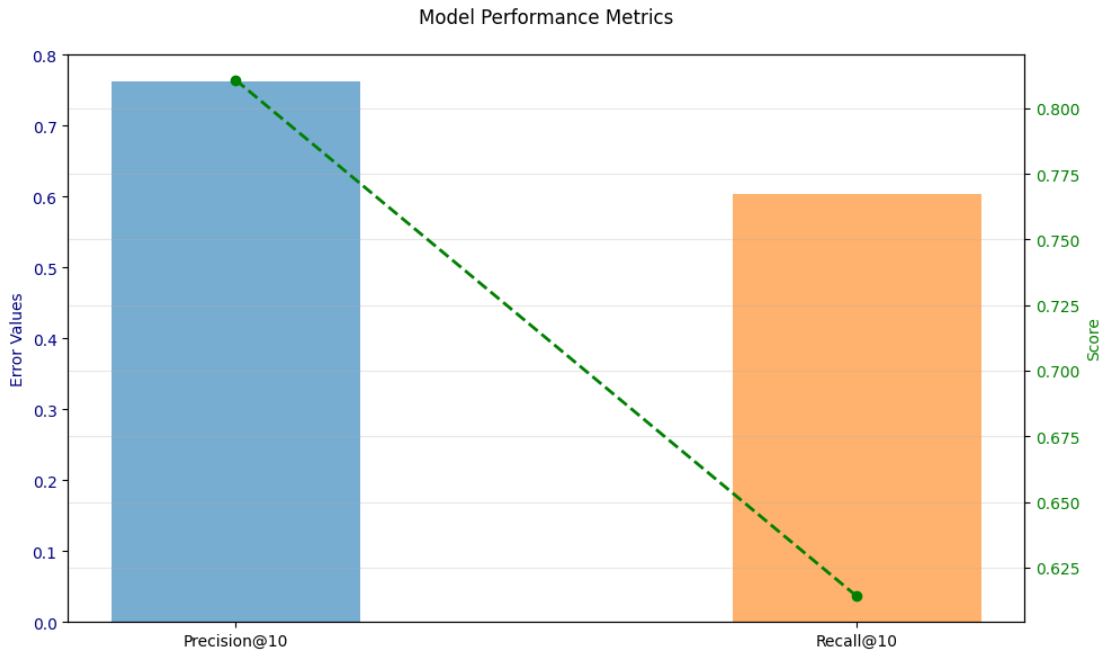


In [9]:
def enhanced_demo(user_id=123, n_recommendations=5):
    """Interactive recommendation demo"""
    try:
        # Initialize components
        loader = DataLoader()
        ratings, movies = loader.load_data()
        
        engine = RecommendationEngine()
        engine.train(ratings)
        
        gemini = GeminiEnhancer()
        
        # Generate metrics
        predictions = engine.svd.test(engine.testset)
        metrics = Evaluator.get_metrics(predictions)
        
        # Get recommendations
        recs = engine.recommend(user_id, n_recommendations)
        
        # Prepare user context
        user_history = ratings[ratings['user_id'] == user_id].merge(
            movies, on='movie_id'
        )
        sample_titles = user_history['clean_title'].sample(3).tolist() if not user_history.empty else []
        user_context = "movies like " + ", ".join(sample_titles) if sample_titles else "various movies"
        
        # Generate output
        results = []
        for movie_id, rating in recs:
            try:
                movie_data = movies[movies['movie_id'] == movie_id].iloc[0]
                explanation = gemini.generate_insight(movie_data['clean_title'], user_context)
                
                results.append(f"""
**{movie_data['clean_title']}** ({movie_data.get('release_year', '')})
- ⭐ Predicted Rating: {rating:.1f}/5
- 📌 Genres: {movie_data.get('genres', '').replace('|', ', ')}
- 💡 Insight: {explanation}
-----------------------------------
                """)
            except Exception as e:
                results.append(f"Error showing recommendation: {str(e)}")
                continue
        
        # Display results
        display(Markdown(f"""
## 🚀 Recommendations for User #{user_id}
### Model Performance
- RMSE: {metrics['rmse']:.3f}
- MAE: {metrics['mae']:.3f}
- Precision@10: {metrics['precision']:.2%}
- Recall@10: {metrics['recall']:.2%}

{''.join(results)}
        """))
        
        # Show metrics plot
        plot_metrics(metrics)

        
    except Exception as e:
        display(Markdown(f"## ❌ Demo Error\n{str(e)}"))

Computing the cosine similarity matrix...
Done computing similarity matrix.



## 🚀 Recommendations for User #123
### Model Performance
- RMSE: 0.766
- MAE: 0.604
- Precision@10: 81.02%
- Recall@10: 61.44%


**Close Shave, A** (1995)
- ⭐ Predicted Rating: 4.5/5
- 📌 Genres: animation, comedy, thriller
- 💡 Insight: Someone who enjoys Vertigo, Casablanca, and Silence of the Lambs likely appreciates suspenseful narratives, morally complex characters, and distinctive visual styles, all of which are present in the tightly-plotted and darkly humorous "Close Shave, A." They'd also be drawn to the film's blend of classic film noir elements with uniquely quirky and British sensibilities, creating a suspenseful yet charming experience.

-----------------------------------
                
**Wrong Trousers, The** (1993)
- ⭐ Predicted Rating: 4.4/5
- 📌 Genres: animation, comedy
- 💡 Insight: Someone who enjoys Vertigo, Casablanca, and Silence of the Lambs would likely appreciate "The Wrong Trousers" due to its suspenseful plot, clever use of mystery, and classic film noir undertones despite its comedic nature. The film's intricate plot, suspenseful moments, and clever twists echo the sophisticated storytelling and stylistic elements found in those other films.

-----------------------------------
                
**Rear Window** (1954)
- ⭐ Predicted Rating: 4.4/5
- 📌 Genres: mystery, thriller
- 💡 Insight: They would likely appreciate "Rear Window" for its suspenseful exploration of voyeurism, paranoia, and moral ambiguity, reminiscent of themes in "Vertigo" and "Silence of the Lambs." Additionally, the film's masterful use of confined spaces, Hitchcock's signature style, and a compelling mystery would resonate with fans of visually driven narratives like "Casablanca."

-----------------------------------
                
**Usual Suspects, The** (1995)
- ⭐ Predicted Rating: 4.4/5
- 📌 Genres: crime, thriller
- 💡 Insight: They would likely enjoy "The Usual Suspects" because it shares a love for intricately plotted narratives with unreliable narrators and a sense of pervasive unease, similar to the films they appreciate. Moreover, the film's noir-inspired style, featuring morally ambiguous characters and a twist ending, resonates with the thematic depth and stylistic sensibilities present in "Vertigo," "Casablanca," and "The Silence of the Lambs."

-----------------------------------
                
**Schindler's List** (1993)
- ⭐ Predicted Rating: 4.4/5
- 📌 Genres: drama, war
- 💡 Insight: Someone who appreciates the suspenseful storytelling and psychological depth of Vertigo and Silence of the Lambs, along with the moral complexities and powerful emotions evoked by Casablanca, would likely be drawn to Schindler's List for its exploration of morality in the face of unimaginable evil and its emotionally gripping, visually striking cinematic presentation. All these films share themes of suspense, human drama, and impactful storytelling.

-----------------------------------
                
        

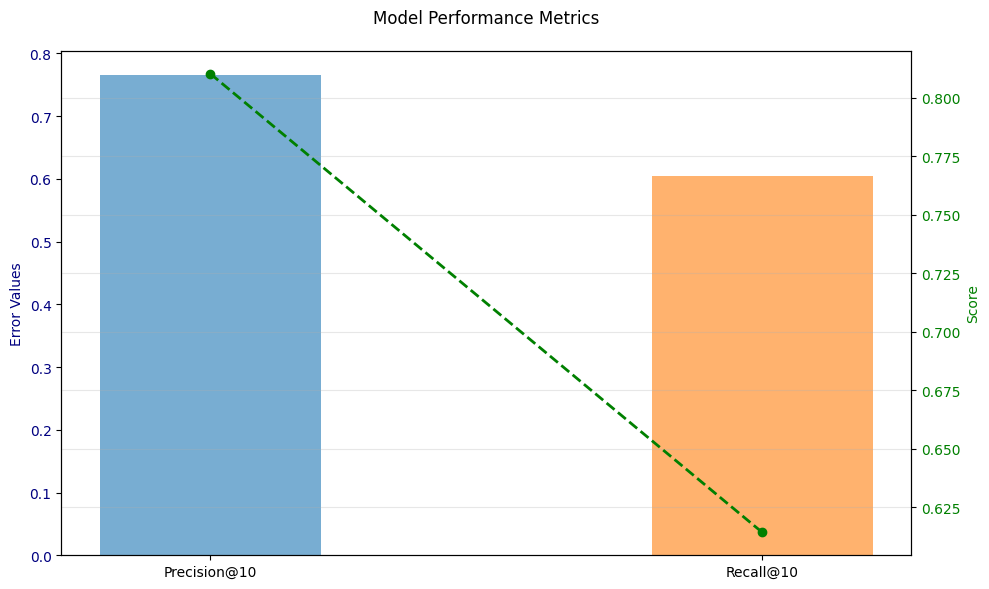

In [10]:
# Generates demo output as well as Model Performance report and graph
enhanced_demo()

# 🚀 Future Scope for the Recommendation System Project

- 🎯 **Add rating thresholds to `get_popular_by_genre`**  
  Introduce minimum rating cutoffs to ensure only highly-rated movies are considered popular in each genre, improving recommendation quality.

- ⚖️ **Implement weighted hybrid scoring**  
  Combine collaborative filtering and content-based recommendations with tunable weights to balance personalization and diversity.

- 🖼️ **Add movie posters from TMDB API**  
  Enhance recommendations visually by fetching official movie posters using The Movie Database (TMDB) API for richer user experience.

- ✍️ **Include user rating submission**  
  Allow users to submit or update their own movie ratings, enabling real-time model updates and more personalized recommendations.

- 🌈 **Add diversity metrics to avoid similar recommendations**  
  Incorporate diversity-aware metrics to ensure recommendations span varied genres and styles, preventing repetitive suggestions.

- 🔄 **Hybrid recommendation fallback strategies**  
  Implement smart fallback logic combining popularity, genre, and similarity to handle cold-start users or sparse data scenarios gracefully.

- 📊 **Genre-based filtering with popularity thresholds**  
  Refine genre filters by applying popularity thresholds to maintain relevance without losing diversity.

- 🔍 **Similarity-based suggestions with content awareness**  
  Leverage metadata and content features for smarter similarity calculations that respect movie themes and styles.

- 🛠️ **Proper error handling and monitoring**  
  Add comprehensive error tracking, logging, and alerting to maintain system stability and quickly resolve issues.

- ⚡ **Performance-optimized data loading**  
  Optimize data pipelines and caching for faster model training and recommendation generation, improving scalability.
